```{index} single: application; portfolio
```
```{index} single: application; investment
```
```{index} single: solver; cplex
```

# Markowitz portfolio optimization revisited

In [1]:
# install Pyomo and solvers
import sys
import os

SOLVER_CONIC = "ipopt"

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre >/dev/null 2>/dev/null
    !idaes get-extensions --to ./bin 
    os.environ['PATH'] += ':bin'
    
    SOLVER_CONIC = "ipopt"

In [2]:
from IPython.display import Markdown, HTML
import numpy as np
import pyomo.environ as pyo
import matplotlib.pyplot as plt

## Problem description and model formulation

Consider again the [Markowitz portfolio optimization](../05/markowitz_portfolio.ipynb) we presented earlier in Chapter 5. Recall that the matrix $\Sigma$ describes the covariance among the uncertain return rates $r_i$, $i=1,\dots, n$. Since $\Sigma$ is positive semidefinite by definition, it allows for a Cholesky factorization, namely $\Sigma = B B^\top$. We can then rewrite the quadratic constraint as $\|B^\top x \|_2 \leq \gamma$ and thus as $(\gamma, B^\top x) \in \mathcal{L}^{n+1}$ using the Lorentz cone. In this way, we realize that the original portfolio problem we formulated [earlier](../05/markowitz_portfolio.ipynb) is in fact a conic quadratic optimization problem, which can thus be solved faster and more reliably. The optimal solution of that problem was the one with the maximum expected return while allowing for a specific level $\gamma$ of risk. 

However, an investor could aim for a different trade-off between return and risk and formulate a slightly different optimization problem, namely

$$
\begin{align*}
    \max \quad  &  R \tilde{x} + \mu^\top x - \alpha x^\top \Sigma x \\
    \text{s.t.}\quad
    & \sum_{i=1}^n x_i + \tilde{x}  = C  \\
    & \tilde x \geq 0\\
    & x_i \geq 0 & \forall \, i=1,\dots,n. 
\end{align*}
$$

where $\alpha \geq 0$ is a *risk tolerance* parameter that describes the relative importance of return vs. risk for the investor.

The risk, quantified by the variance of the investment return $x^\top \Sigma x = x^\top B^\top B x$, appears now in the objective function as a penalty term. Note that even in this new formulation we have a conic problem since we can rewrite it as

$$
\begin{align*}
    \max \quad  &  R \tilde{x} + \mu^\top x - \alpha s \\
    \text{s.t.}\quad
    & \sum_{i=1}^n x_i + \tilde{x}  = C  \\
    & \| B^\top x\|^2_2 \leq s \\
    & \tilde x \geq 0 \\
    & s \geq 0\\
    & x_i \geq 0 & \forall \, i=1,\dots,n. 
\end{align*}
$$

Solving for all values of $\alpha \geq 0$, one can obtain the so-called **efficient frontier**.

In [3]:
# Specify the initial capital, the risk tolerance, and the guaranteed return rate. 
C = 1
alpha = 0.1
R = 1.05

# Specify the number of assets, their expected return, and their covariance matrix.
n = 3
mu = np.array([1.25, 1.15, 1.35])
Sigma = np.array([[1.5, 0.5, 2], [0.5, 2, 0], [2, 0, 5]])

# If you want to change the covariance matrix Sigma, ensure you input a semi-definite positive one.
# The easiest way to generate a random covariance matrix is first generating a random m x m matrix A 
# and then taking the matrix A^T A (which is always semi-definite positive)
# m = 3
# A = np.random.rand(m, m)
# Sigma = A.T @ A

def markowitz_revisited(alpha, mu, Sigma):
    
    model = pyo.ConcreteModel("Markowitz portfolio optimization revisited")

    model.xtilde = pyo.Var(domain=pyo.NonNegativeReals)
    model.x = pyo.Var(range(n), domain=pyo.NonNegativeReals)
    model.s = pyo.Var(domain=pyo.NonNegativeReals)

    @model.Objective(sense=pyo.maximize)
    def objective(m):
        return mu @ m.x + R * m.xtilde - alpha*m.s

    @model.Constraint()
    def bounded_variance(m):
        return (m.x @ (Sigma @ m.x)) <= m.s**2

    @model.Constraint()
    def total_assets(m):
        return sum(m.x[i] for i in range(n)) + m.xtilde == C

    result = pyo.SolverFactory(SOLVER_CONIC).solve(model)
    
    return result, model

result, model = markowitz_revisited(alpha, mu, Sigma)

display(Markdown(f"**Solver status:** *{result.solver.status}, {result.solver.termination_condition}*"))
display(Markdown(f"**Solution:** $\\tilde x = {model.xtilde.value:.3f}$, $x_1 = {model.x[0].value:.3f}$,  $x_2 = {model.x[1].value:.3f}$,  $x_3 = {model.x[2].value:.3f}$"))
display(Markdown(f"**Maximizes objective value to:** ${model.objective():.2f}$"))

**Solver status:** *ok, optimal*

**Solution:** $\tilde x = 0.000$, $x_1 = 0.589$,  $x_2 = 0.000$,  $x_3 = 0.411$

**Maximizes objective value to:** $1.14$

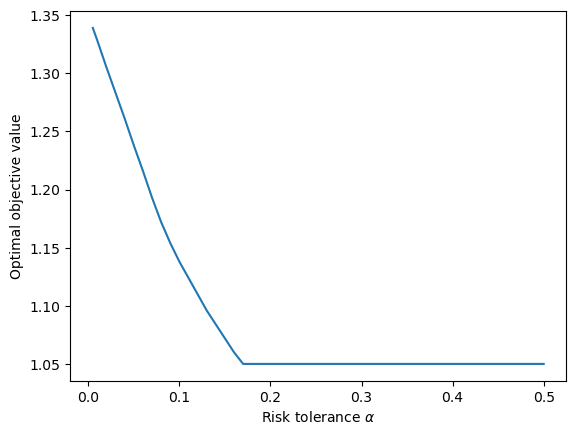

In [4]:
alpha_values = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.20, 0.25, 0.5]
objective = []

for alpha in alpha_values:
    _, model = markowitz_revisited(alpha, mu, Sigma)
    objective.append(round(model.objective(),3))
    
plt.plot(alpha_values, objective)
plt.xlabel(r'Risk tolerance $\alpha$')
plt.ylabel('Optimal objective value')
plt.show()